In [1]:
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim

ModuleNotFoundError: No module named 'opencv'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import sys
sys.path.append('../')

In [4]:
from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
from notebooks import visualization

In [5]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

In [6]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
ckpt_filename = '../checkpoints/ssd_300_vgg.ckpt'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
print(isess.run(tf.global_variables_initializer()))
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

None
INFO:tensorflow:Restoring parameters from ../checkpoints/ssd_300_vgg.ckpt


In [7]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

between time: 0.6529762744903564


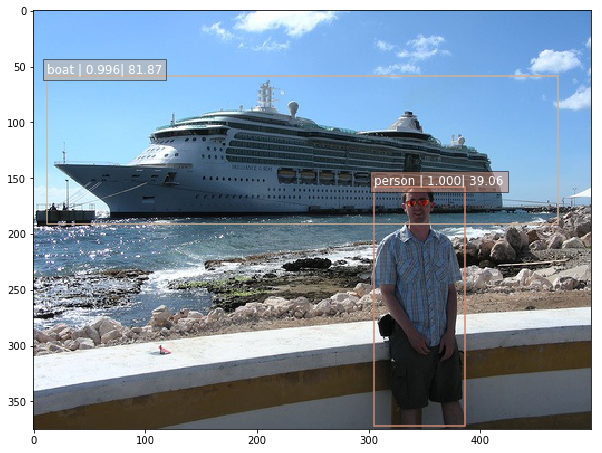

In [8]:
# Test on some demo image and visualize output.
import time
path = '../demo/'
image_names = sorted(os.listdir(path))

img = mpimg.imread(path + image_names[-5])
start = time.time()
rclasses, rscores, rbboxes =  process_image(img)
end = time.time()
print("between time:",end-start)
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

***********
fps: 51
***********
center_x,center_y: 250.0 203.0
newcenter_x,newcenter_y: 285.5 352.0
theta 76.59883813327802
newcenter_x,newcenter_y: 50.0 335.5
theta -33.52447324857696
newcenter_x,newcenter_y: 163.0 340.5
theta -57.67734698858916
newcenter_x,newcenter_y: 429.0 357.5
theta 40.7984123748027
newcenter_x,newcenter_y: 127.0 338.5
theta -47.7684324930359
newcenter_x,newcenter_y: 211.0 345.0
theta -74.64250657650237
newcenter_x,newcenter_y: 99.5 337.0
theta -41.68076436565594


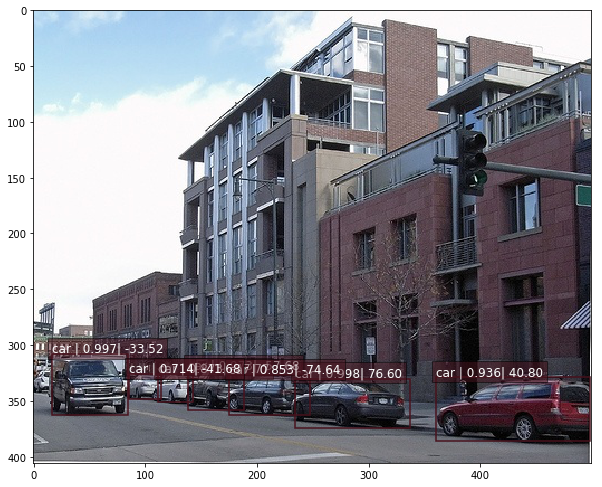

***********
fps: 63
***********
center_x,center_y: 250.0 167.0
newcenter_x,newcenter_y: 184.5 202.5
theta -28.457016595437466
newcenter_x,newcenter_y: 202.0 137.0
theta 32.005383208083494
newcenter_x,newcenter_y: 47.0 254.5
theta -23.317708386755065


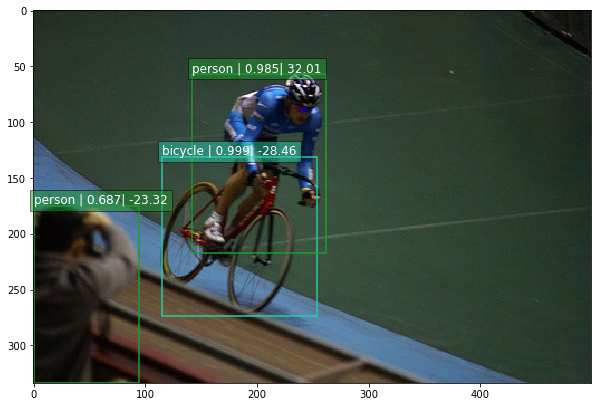

***********
fps: 65
***********
center_x,center_y: 166.5 250.0
newcenter_x,newcenter_y: 266.0 339.0
theta 41.811752695017375
newcenter_x,newcenter_y: 92.5 336.5
theta -49.453298744393905
newcenter_x,newcenter_y: 210.5 268.0
theta 22.24902365721237
newcenter_x,newcenter_y: 145.0 266.5
theta -37.504142360270144
newcenter_x,newcenter_y: 179.0 267.5
theta 54.46232220802562


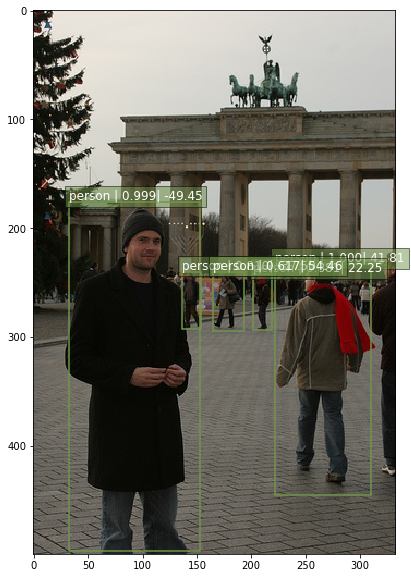

***********
fps: 65
***********
center_x,center_y: 250.0 187.5
newcenter_x,newcenter_y: 261.5 273.5
theta 82.38353798070654
newcenter_x,newcenter_y: 295.0 217.0
theta 33.247067749335855


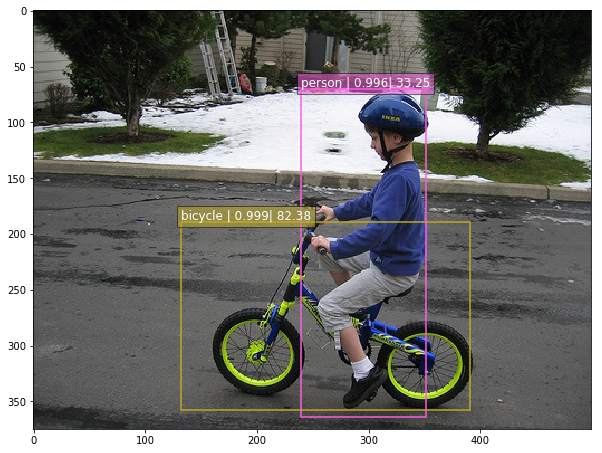

***********
fps: 69
***********
center_x,center_y: 250.0 166.5
newcenter_x,newcenter_y: 245.0 201.5
theta -81.86989764584403
newcenter_x,newcenter_y: 215.0 141.5
theta 35.53767779197438


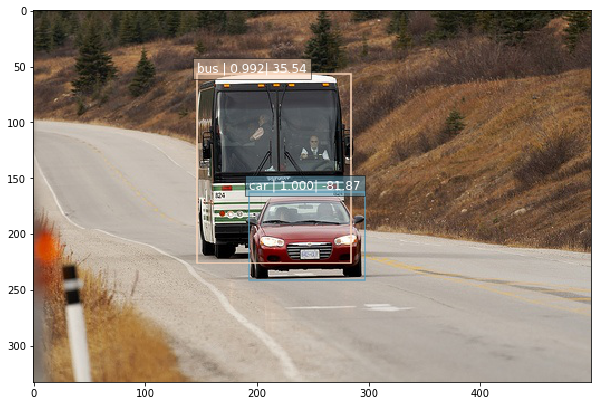

***********
fps: 69
***********
center_x,center_y: 250.0 165.5
newcenter_x,newcenter_y: 130.0 165.0
theta 0.23873103309890856
newcenter_x,newcenter_y: 422.5 144.0
theta -7.104575472311628
newcenter_x,newcenter_y: 238.5 150.5
theta 52.52382043863863
newcenter_x,newcenter_y: 321.5 166.5
theta 0.8012873301070143
newcenter_x,newcenter_y: 234.5 183.5
theta -49.26789330029081
newcenter_x,newcenter_y: 423.0 110.5
theta -17.636453072608305


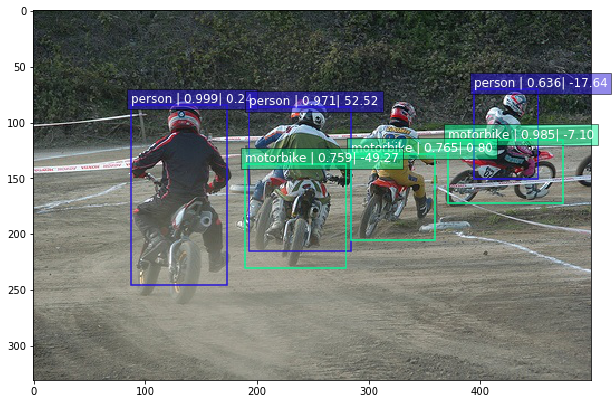

***********
fps: 60
***********
center_x,center_y: 665.0 665.0
newcenter_x,newcenter_y: 815.0 683.5
theta 7.030973299151757
newcenter_x,newcenter_y: 1007.0 866.5
theta 30.505796131042526
newcenter_x,newcenter_y: 597.0 698.5
theta -26.227026901140448
newcenter_x,newcenter_y: 176.0 748.0
theta -9.633240499714203
newcenter_x,newcenter_y: 1023.5 771.5
theta 16.54516452221016
newcenter_x,newcenter_y: 651.0 631.0
theta 67.61986494804043
newcenter_x,newcenter_y: 409.0 632.5
theta 7.235173924323652
newcenter_x,newcenter_y: 372.5 630.0
theta 6.823462399033519
newcenter_x,newcenter_y: 239.5 633.0
theta 4.300869572421534
newcenter_x,newcenter_y: 340.0 627.0
theta 6.668918564748624


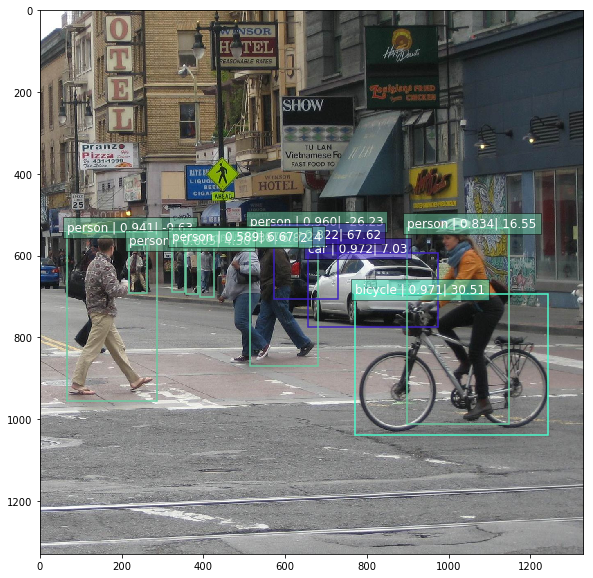

***********
fps: 69
***********
center_x,center_y: 250.0 166.5
newcenter_x,newcenter_y: 342.0 250.0
theta 42.227157522404035
newcenter_x,newcenter_y: 166.0 197.5
theta -20.256462174523122
newcenter_x,newcenter_y: 214.5 221.0
theta -56.92073853992231
newcenter_x,newcenter_y: 456.0 202.5
theta 9.912751446723837


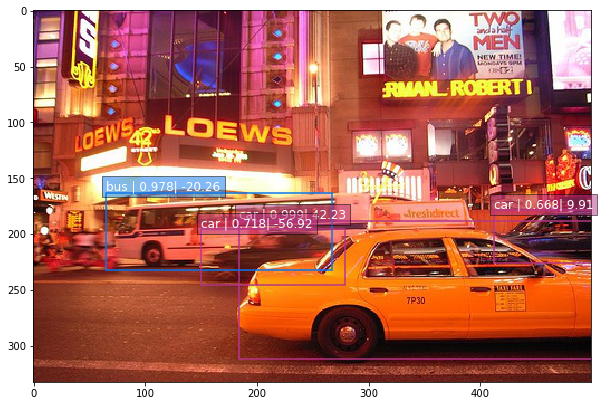

***********
fps: 68
***********
center_x,center_y: 243.0 250.0
newcenter_x,newcenter_y: 262.5 216.5
theta -59.79676224505734


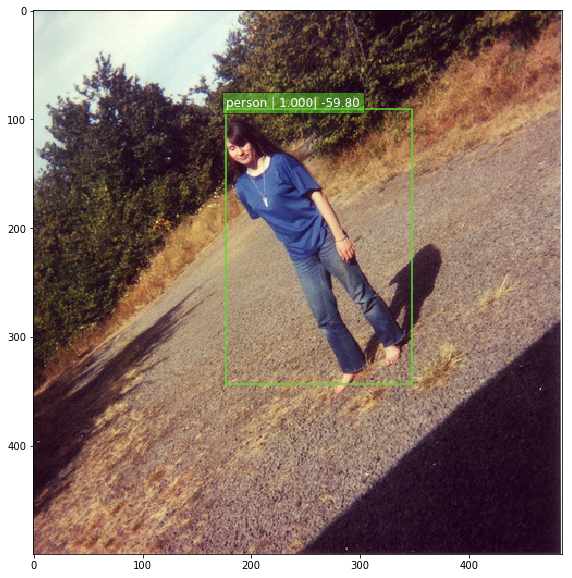

***********
fps: 68
***********
center_x,center_y: 250.0 187.5
newcenter_x,newcenter_y: 217.5 210.5
theta -35.28674897505972
newcenter_x,newcenter_y: 219.0 173.0
theta 25.06746343806047


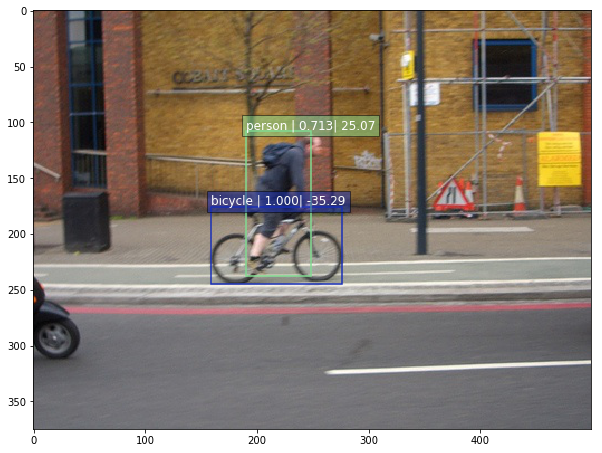

***********
fps: 67
***********
center_x,center_y: 250.0 187.5
newcenter_x,newcenter_y: 345.5 265.0
theta 39.059962747699366
newcenter_x,newcenter_y: 241.0 124.5
theta 81.86989764584403


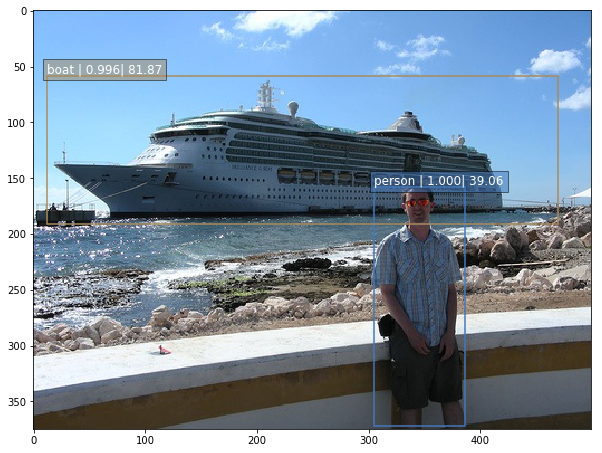

***********
fps: 61
***********
center_x,center_y: 250.0 187.5
newcenter_x,newcenter_y: 254.5 181.0
theta -55.30484646876604


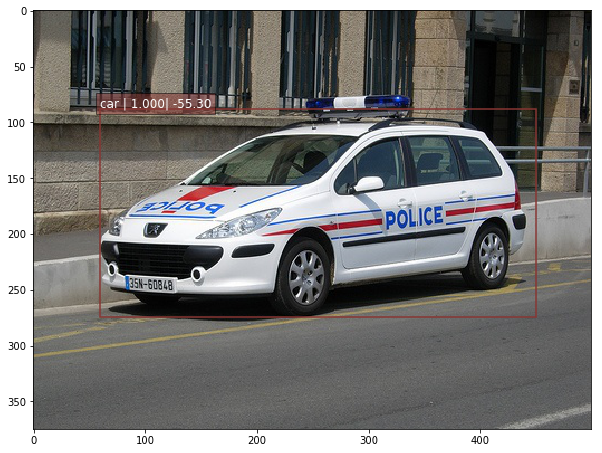

***********
fps: 69
***********
center_x,center_y: 250.0 187.5
newcenter_x,newcenter_y: 260.0 174.0
theta -53.47114463301484
newcenter_x,newcenter_y: 413.5 128.0
theta -19.99717373976441


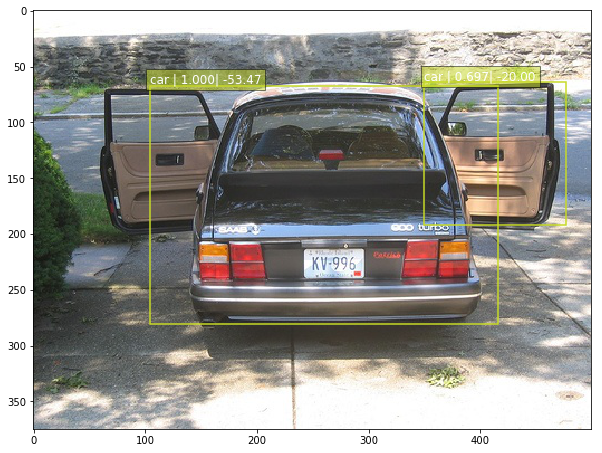

***********
fps: 68
***********
center_x,center_y: 250.0 187.5
newcenter_x,newcenter_y: 167.0 223.0
theta -23.15692086316721
newcenter_x,newcenter_y: 348.0 223.5
theta 20.170653411850402
newcenter_x,newcenter_y: 61.5 223.0
theta -10.665528588621434
newcenter_x,newcenter_y: 407.5 186.5
theta -0.36377783886457454
newcenter_x,newcenter_y: 96.0 210.5
theta -8.494375789808984
newcenter_x,newcenter_y: 14.5 220.0
theta -7.857429673801948
newcenter_x,newcenter_y: 465.0 232.5
theta 11.821488340607257


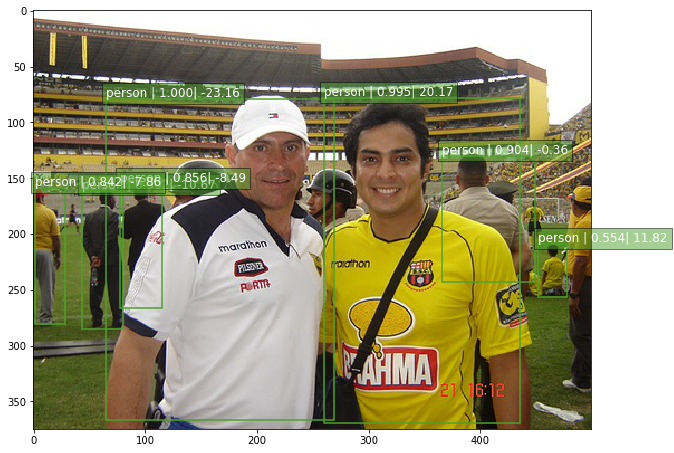

***********
fps: 69
***********
center_x,center_y: 250.0 187.5
newcenter_x,newcenter_y: 23.0 257.0
theta -17.022880458401648
newcenter_x,newcenter_y: 119.0 235.5
theta -20.123451077742956
newcenter_x,newcenter_y: 54.5 249.0
theta -17.462428688786076


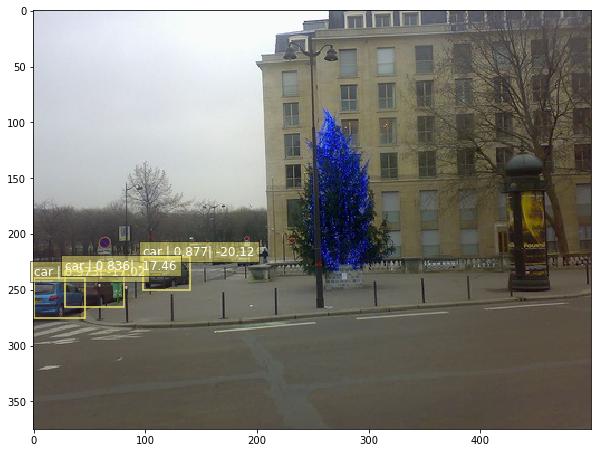

In [9]:
# Test on some demo image and visualize output.
import time
path = '../demo/'
image_names = sorted(os.listdir(path))
#print("len(image_names)",len(image_names))

for i in range(len(image_names)):  

    img = mpimg.imread(path + image_names[i])  
    start = time.time()

    rclasses, rscores, rbboxes =  process_image(img)
    
    end = time.time()
    print("***********")
    #print("between time:",end-start)
    print("fps:",int(1/(end-start)))
    print("***********")
    visualization.plt_bboxes(img, rclasses, rscores, rbboxes)


